In [1]:
import mts
import algorithm as al
import cv2
import processing
from visualize import visualize_cv2, visualize_mts, visualize_al
# dataset = mts.dataset
# print(dir(mts))
# Don't try to run this cell more than once, you'll run out of memory

/home/saratoga/miniforge3/envs/mtl/lib/python3.11/site-packages/fastai/basic_train.py:621: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(source, map_locat

In [99]:
def mts_process(image_path):
    model = mts.MTS
    layer_agreement = 2
    im, pred = model.process(image_path)
    total = sum(p[0].px for p in pred)
    total[total < layer_agreement] = 0.
    total[total >= layer_agreement] = 1.
    return (total, im)

def cv2_process(image_path, method):
    im = cv2.imread(image_path)
    chars, chains, sep = method.process(im)
    polys = processing.convert_pointslist_to_polygons(chars)
    # polys = [p.simplify(0.1) for p in polys]
    total = processing.condense(polys)
    # print(total)
    return (processing.convert_polygons_to_pointslist(total), im)
sample = "images/shegreat_0020.png"
sample_line = "images/shegreat_0020_line.png"

In [3]:
# g1 = mts_process(sample)
# visualize_mts(*g1)

<module 'matplotlib.pyplot' from '/home/saratoga/miniforge3/envs/mtl/lib/python3.11/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

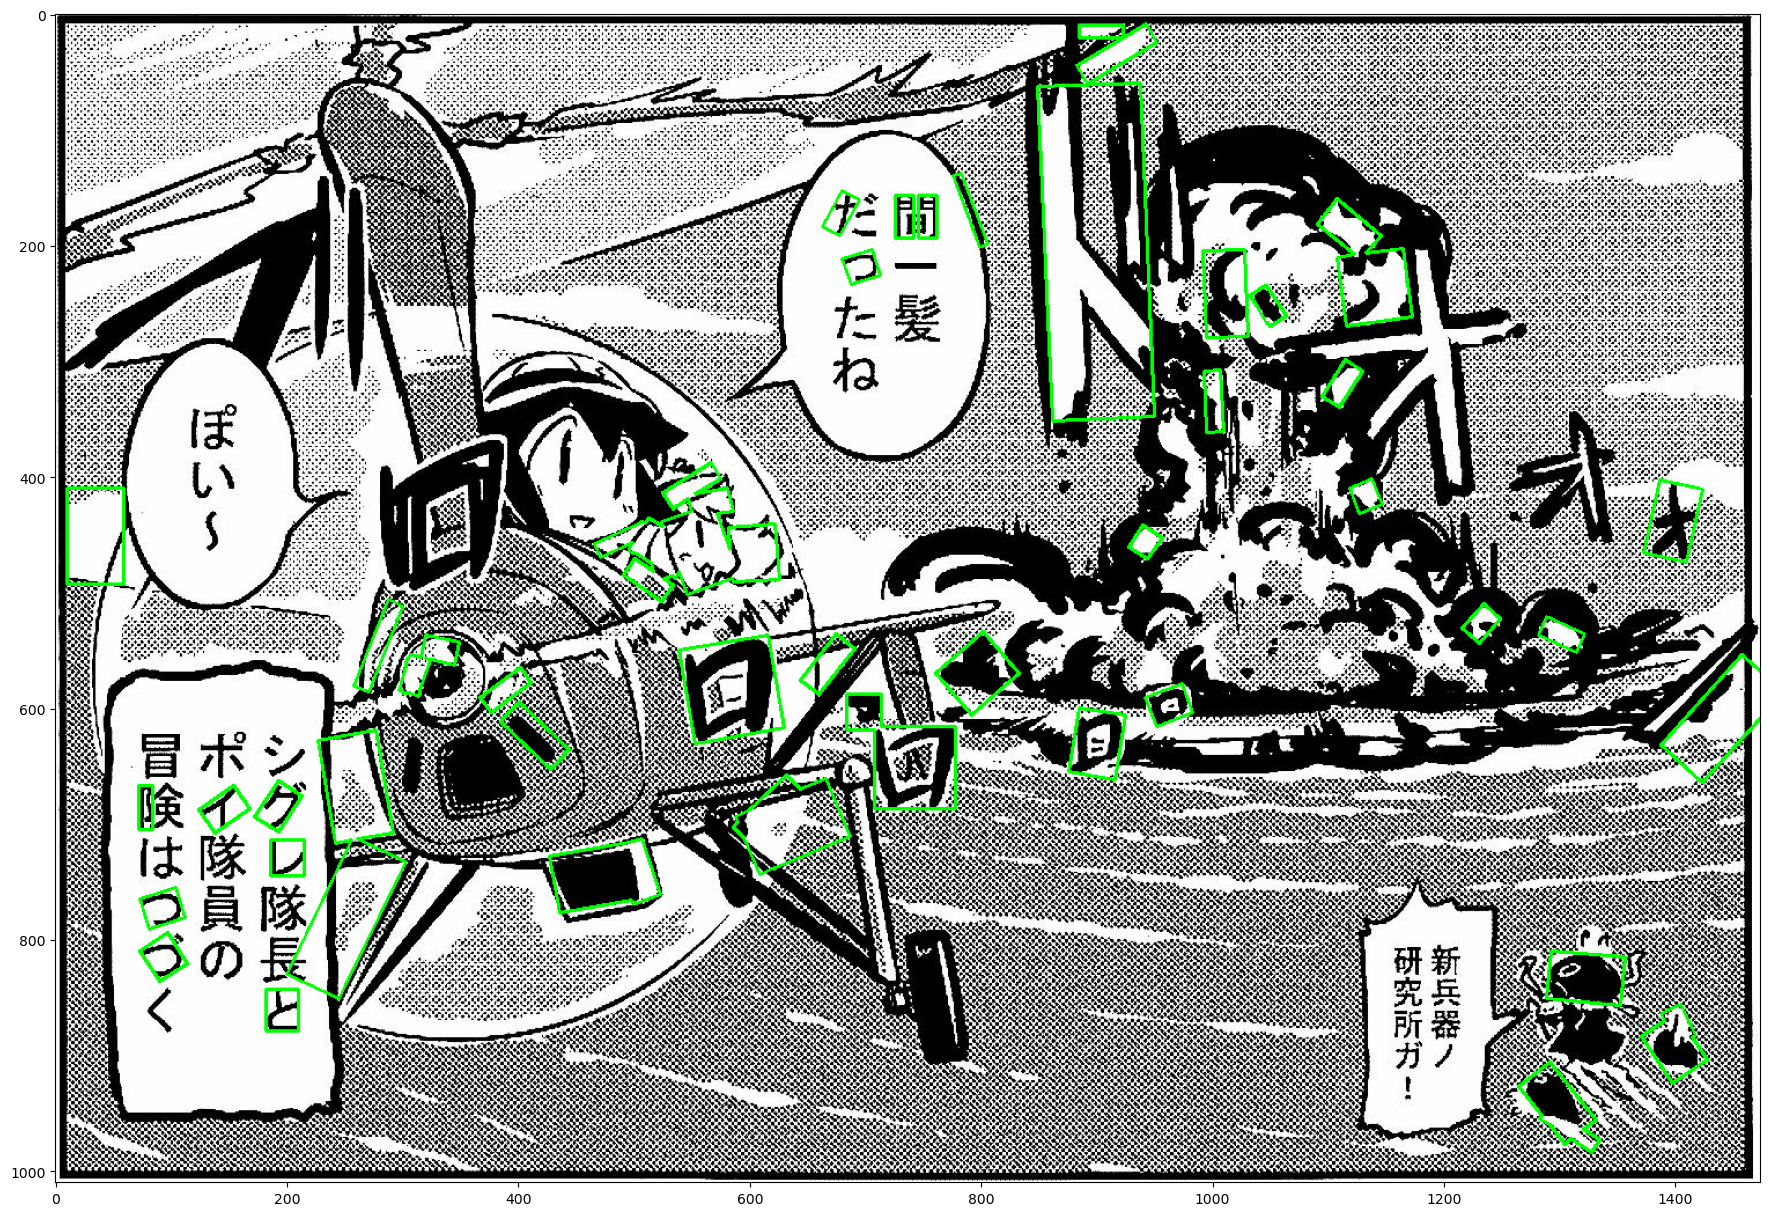

In [16]:
model = al.Text_ER()
# model.er1 = cv2.text.createERFilterNM1(model.erc1, 16, 0.00005, 0.7, 0.25, True, 0.05)
g2 = cv2_process(sample, al.Text_ER())
visualize_al(*g2)

598
[[[      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  ...
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]]

 [[      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  ...
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]]

 [[      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  ...
  [      0       0    1480    1016 1373055]
  [      0       0    1480    1016 1373055]
  [   

NameError: name 'x' is not defined

<Figure size 640x480 with 0 Axes>

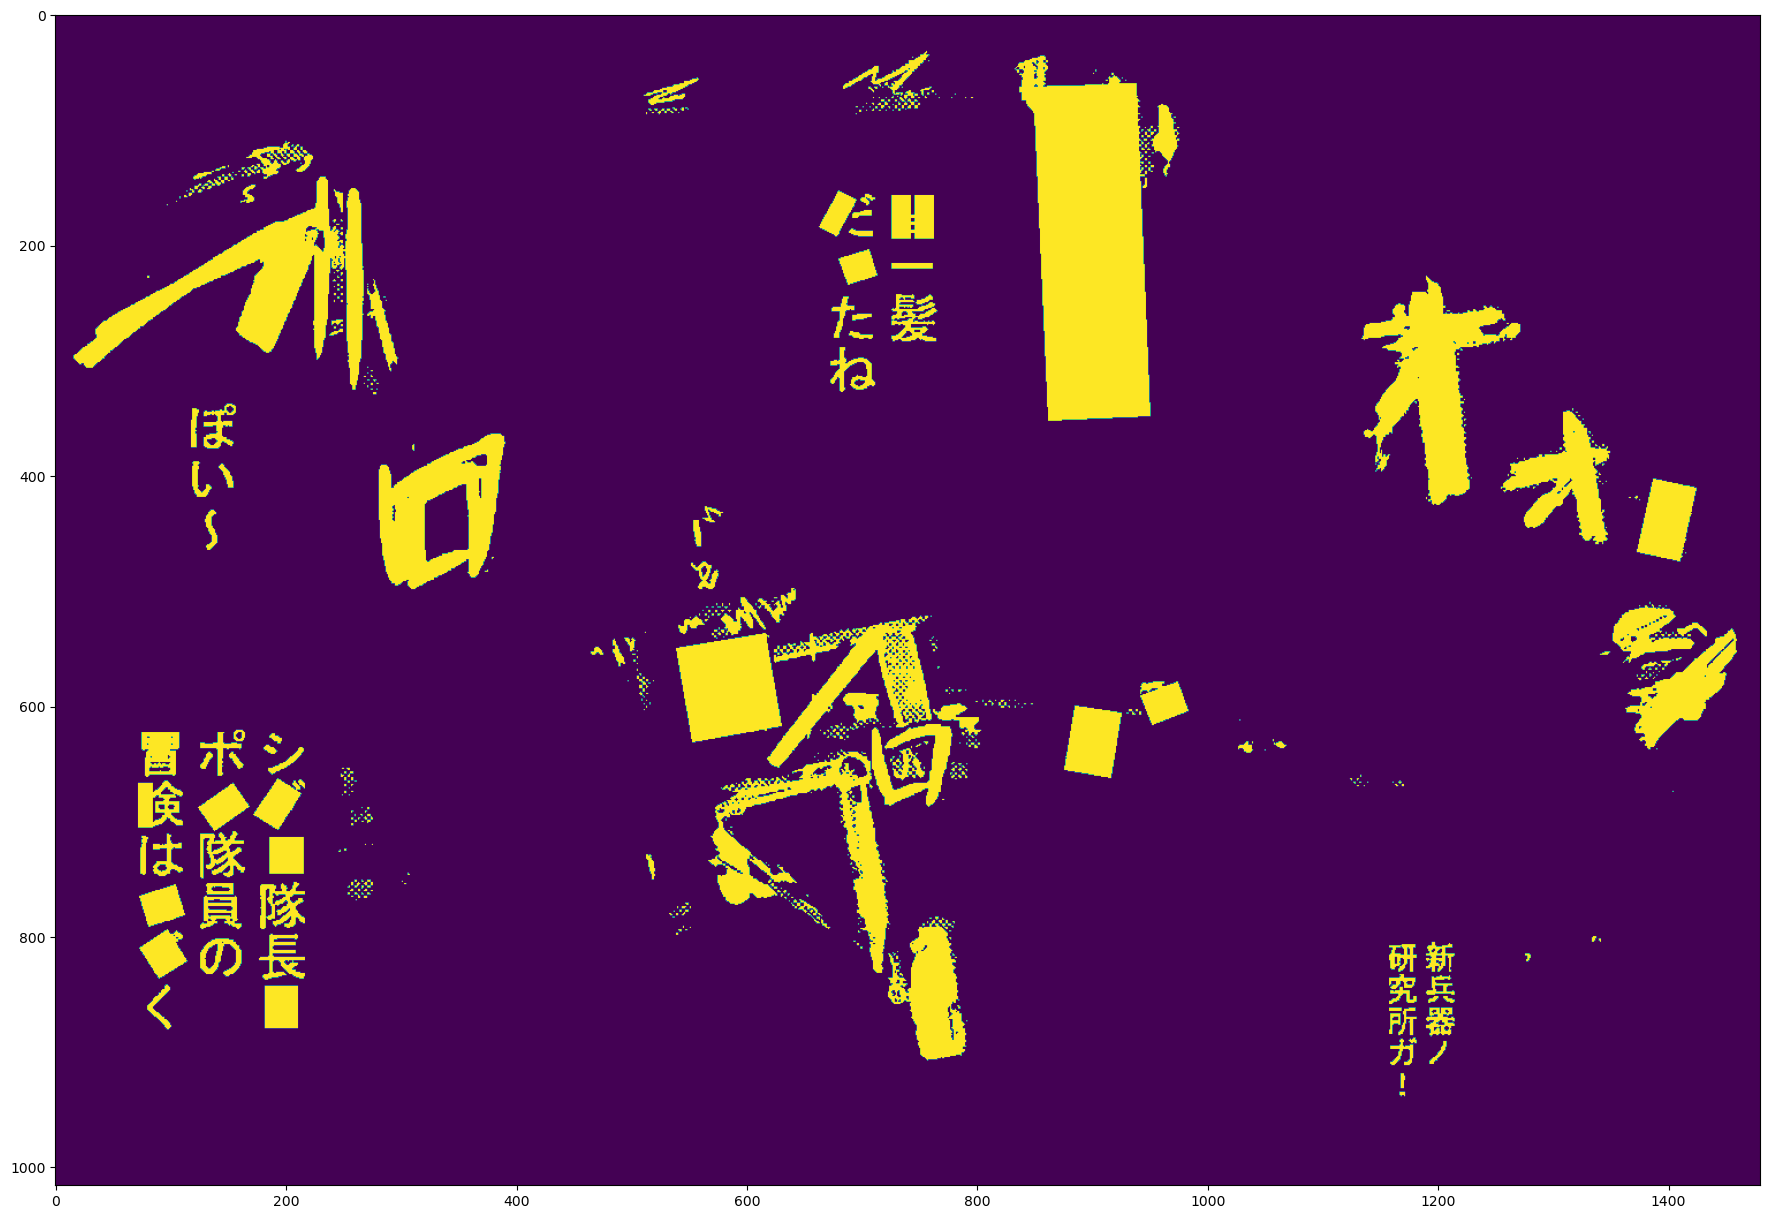

In [113]:
import numpy as np
from shapely import normalize
# Now we need to merge two results
class TextDetectionResult:
    # Mask
    mask: np.array
    # List of bounding boxes
    bbs: list
    def __init__(self, mask, bbs):
        self.mask = mask
        self.bbs = bbs

def dup_check(chars, isPoly=False):
    ccs = chars if isPoly else processing.convert_pointslist_to_polygons(chars)
    for i, char in enumerate(ccs):
        dup = list([i])
        for j, char_2 in enumerate(ccs):
            if i != j and char.equals_exact(char_2, tolerance=0.5):
                dup.append(j) 
        assert len(dup) == 1, "There are {} duplicate of {} at index {}: {}".format(len(dup), char, dup, [ccs[i] for i in dup])


# Since we are building based of segmentation result,
# we need to convert mask into polygon

def convert_mask_to_points(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        # Reshape to (n, 2) array
        p = contour.reshape((-1, 2))
        polygons.append(p)
    return polygons

def text_detection():
    # First, we use MTS to find the base mask of text
    mask, _ = mts_process(sample)
    # We will build bb based on 
    mask_np = np.array(mask[0], dtype=np.uint8) * 255
    # print(mask_np.shape)
    polys_cv2 = convert_mask_to_points(mask_np)
    # print(polys_cv2)
    # visualize_al(polys_cv2, cv2.imread(sample))

    # Post-Processing 1: We use TextER in algorithm to find SFX
    polys = processing.convert_pointslist_to_polygons([p for p in polys_cv2 if len(p) > 3])
    # Remove noises
    polys = [p for p in polys if p.area > 25]
    # visualize_al(processing.convert_polygons_to_pointslist(polys), cv2.imread(sample))

    model = al.Text_ER()
    # model.er1 = cv2.text.createERFilterNM1(model.erc1, 16, 0.00005, 0.7, 0.25, True, 0.05)
    chars, _ = cv2_process(sample, model)

    # dup_check(chars)

    marks = []
    for char in chars:
        # We are dropping anything beyond 10-edges
        if len(char) > 10:
            continue
        overlaps = 0
        box = processing.convert_points_to_polygon(char)
        for i in range(len(polys)):
            p = polys[i]
            if p.overlaps(box) or p.intersects(box):
                inter = normalize(p.intersection(box))
                if inter.area / p.area > 0.4:
                    overlaps += 1
        if overlaps > 0:
            marks.append(char)
                    
    # visualize_cv2(mask_np)
    new_mask = cv2.cvtColor(mask_np, cv2.COLOR_GRAY2RGB)
    new_draw = cv2.drawContours(new_mask, marks, -1, color=(255, 255, 255), thickness=cv2.FILLED)
    # for i in range(len(marks)):
    #     new_draw = cv2.drawContours(new_mask, marks, i, color=(i, 255, i), thickness=cv2.FILLED)
    # visualize_cv2(new_draw)
    pp1_mask = cv2.cvtColor(new_draw, cv2.COLOR_RGB2GRAY)

    mask = pp1_mask
    # Post-Processing 2: cleanup dust

    # contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
    # for contour in contours:
    #     area = cv2.contourArea(contour)
    #     hull = cv2.convexHull(contour)
    #     hull_area = cv2.contourArea(hull)
    
    #     if hull_area > 0:
    #         solidity = area / float(hull_area)
    #         if solidity > 0.5:
    #             cv2.drawContours(new_draw, [contour], -1, (0, 255, 0), thickness=cv2.FILLED)
    # visualize_cv2(new_draw)
    
    
    # _, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(mask)
    # sizes = stats[:, cv2.CC_STAT_AREA]
    # im_result = np.where(sizes[im_with_separated_blobs] >= 100, mask, 0)
    # kernel = np.ones((3, 3), np.uint8)
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (16, 16))

    # erosion = cv2.erode(mask, kernel, iterations = 1)
    # dilation = cv2.dilate(erosion, kernel, iterations = 1)
    # opening = cv2.morphologyEx(erosion, cv2.MORPH_BLACKHAT, kernel)
    # visualize_cv2(mask)
    # mask = dilation
    
    # visualize_cv2(erosion)
    # visualize_cv2(dilation)
    visualize_cv2(mask)

    # Now, we need to make them useful

    # count, labels, stats, _ = cv2.connectedComponentsWithStats(mask, 8, cv2.CV_32S)
    # print(count)

    # for label in labels[3:]:
    #     print(stats[labels])
    #     cv2.rectangle(new_draw, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # visualize_cv2(new_draw)
    return mask


text_detection()
    